In [91]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.colors as colors

In [357]:
class Constraint(object):
    def __init__(self, con):
        self.constraints = np.array(con)
        
    def min_tile(self):
        return(self.constraints.sum() + len(self.constraints) - 1)
    
    def n_items(self):
        return len(self.constraints)
    
    def items(self):
        return(self.constraints)
    
    def first(self):
        return(self.constraints[0])
    
    def remaining(self):
        return(self.constraints[1:])
    
    def interval(self, empty, length):
        return(self.constraints[empty, (empty + length)])


class Nonogram(object):
    def __init__(self, rows, cols):
        self.rows = self.parse_input(rows)
        self.cols = self.parse_input(cols)
        self.nrow = len(self.rows)
        self.ncol = len(self.cols)
        self.maxnrow = max([r.n_items() for r in self.rows])
        self.maxncol = max([c.n_items() for c in self.cols])
        self.board = np.zeros(shape=(self.nrow,self.ncol))
        self.printboard = self.get_empty_printboard()
        self.print_mask = self.get_print_mask()
        
    def parse_input(self, cons):
        cons = [[int(i) for i in s.split(',')] for s in cons.split(' ')]
        return([Constraint(c) for c in cons])
        
    def get_empty_printboard(self): 
        
        board_size = np.array([self.maxncol, self.maxnrow]) + self.board.shape
        board = np.zeros(shape=board_size)
        board[0:self.maxncol,:] = None
        board[:,0:self.maxnrow] = None
        
        for i, row in enumerate(self.rows):
            empty = self.maxnrow - row.n_items()
            board[self.maxncol + i, empty:self.maxnrow] = row.items()

        for i, col in enumerate(self.cols):
            empty = self.maxncol - col.n_items()
            board[empty:self.maxncol, self.maxnrow + i] = col.items()
        return(board)
    
    def get_print_mask(self):
        
        board_size = self.printboard.shape
        board = np.zeros(shape=board_size)
        board[0:self.maxncol,] = 1
        board[:,0:self.maxnrow] = 1
        return(board)
    
    def get_uncertain_tiles(self):
        return((self.board == 0).sum())
    
    def get_possible_positions(self, state, con):
        n = len(state)
        probs = n - con.min_tile() + 1
        positions = []
        first_con = con.first()
        rem_con = con.remaining()
        assigned_vals = (state != 0)
        
        def append(state, position):
            if(
                assigned_vals.sum() == 0 
                or (state[assigned_vals] == position[assigned_vals]).min() == 1
            ):
                positions.append(position)

        for empty_left in range(probs):

            if(empty_left > 0 and state[0:(empty_left)].max() == 1):
                continue
            if(state[empty_left:(empty_left+first_con)].min() == -1):
                continue

            filled_tiles = empty_left + first_con
            empty_right = n - filled_tiles
            if(empty_right > 0 and state[filled_tiles] == 1):
                continue

            pos_beginning = np.append(np.full(empty_left, -1), np.full(first_con, 1))
            if(len(rem_con) == 0 or empty_right <= 1):
                append(state, np.append(pos_beginning, np.full(empty_right, -1)))

            else:
                curr_poss = np.append(pos_beginning, [-1])
                rem_poss = self.get_possible_positions(state[(filled_tiles + 1):], Constraint(rem_con))

                for r in rem_poss:
                    append(state, np.append(curr_poss, r))

        return(np.array(positions))

    def get_common_tiles(self, positions):
        n_pos = positions.shape[0]
        n_tile = positions.shape[1]

        output = np.zeros(n_tile)
        for i in range(n_tile):
            vals = positions[:,i]
            if(vals.min() == vals.max()):
                output[i] = vals[0]

        return(output)
    
    def print_board(self, prev_board = None):
        
        board = self.board.copy()
        if(prev_board is not None):
            board[board > prev_board] = 2
            board[board < prev_board] = -2
        
        printboard = self.printboard.copy()
        printboard[self.maxncol:, self.maxnrow:] = board
        
        mask = self.print_mask

        cols = colors.ListedColormap(['red', 'orange', 'gray', 'blue', 'green'])
        ax1 = sns.heatmap(data = printboard, mask = mask, linewidth=1, cbar=False, annot=False, cmap=cols, vmin=-2, vmax=2)
        ax1.set_yticks([])
        ax1.set_xticks([])
        ax2 = sns.heatmap(data = printboard, mask = (1-mask), linewidth=1, cbar=False, annot=True, cmap=colors.ListedColormap(['white']))
        ax2.set_yticks([])
        ax2.set_xticks([])
        plt.show()
    
    def solve(self):
        blank = self.get_uncertain_tiles()
        prev_blank = blank + 1
        
        while(blank > 0 and prev_blank > blank):
            for r in range(self.nrow):
                print('row:', r, 'const', self.rows[r].constraints)
                row = self.board[r]
                if((row == 0).sum() > 0):
                    row_positions = self.get_possible_positions(self.board[r], self.rows[r])
                    prev_board = self.board.copy()
                    self.board[r] = self.get_common_tiles(row_positions)
                    self.print_board(prev_board)
                
            for c in range(self.ncol):
                print('col:', c, 'const', self.cols[c].constraints)
                col = self.board[:,c]
                if((col == 0).sum() > 0):
                    col_positions = self.get_possible_positions(col, self.cols[c])
                    prev_board = self.board.copy()
                    self.board[:,c] = self.get_common_tiles(col_positions)
                    self.print_board(prev_board)
                    
            prev_blank = blank
            blank = self.get_uncertain_tiles()
            print('blank:', blank)

row: 0 const [2]


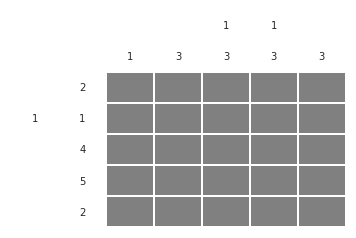

row: 1 const [1 1]


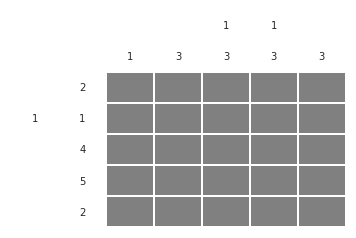

row: 2 const [4]


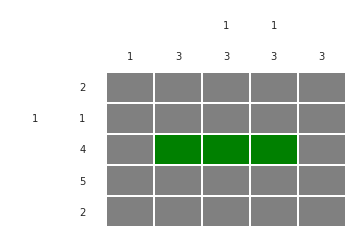

row: 3 const [5]


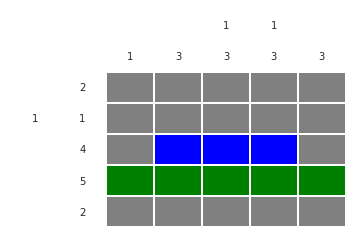

row: 4 const [2]


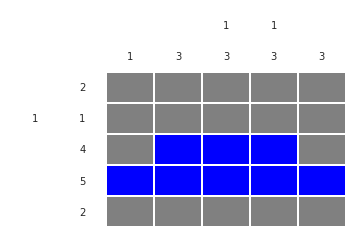

col: 0 const [1]


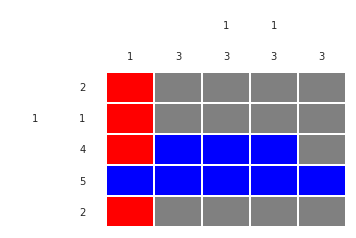

col: 1 const [3]


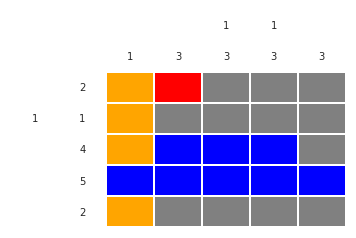

col: 2 const [1 3]


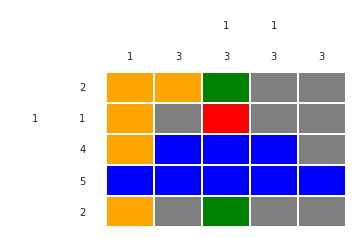

col: 3 const [1 3]


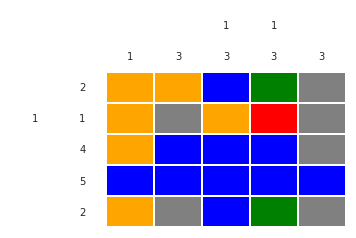

col: 4 const [3]


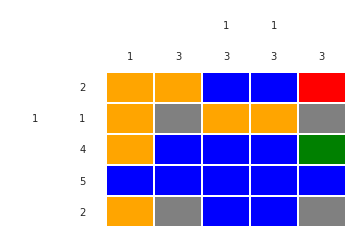

blank: 4
row: 0 const [2]
row: 1 const [1 1]


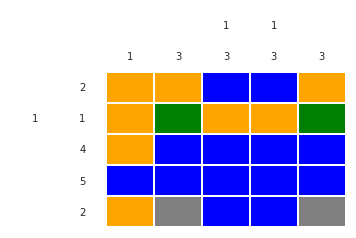

row: 2 const [4]
row: 3 const [5]
row: 4 const [2]


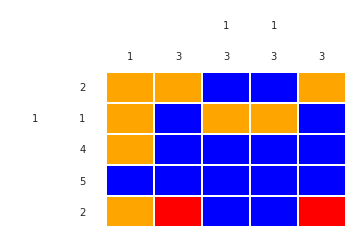

col: 0 const [1]
col: 1 const [3]
col: 2 const [1 3]
col: 3 const [1 3]
col: 4 const [3]
blank: 0


In [358]:
rows = '2 1,1 4 5 2'
cols = '1 3 1,3 1,3 3'
game = Nonogram(rows, cols)
game.solve()

row: 0 const [6]


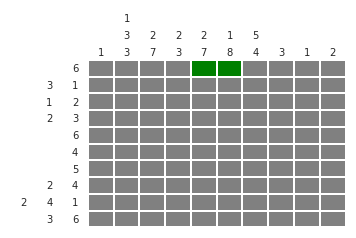

row: 1 const [3 1]


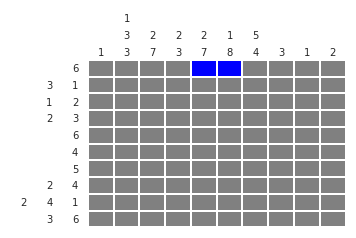

row: 2 const [1 2]


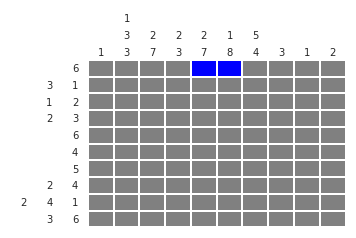

row: 3 const [2 3]


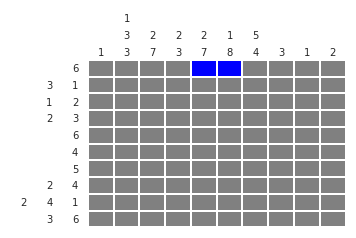

row: 4 const [6]


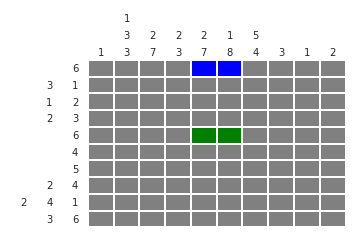

row: 5 const [4]


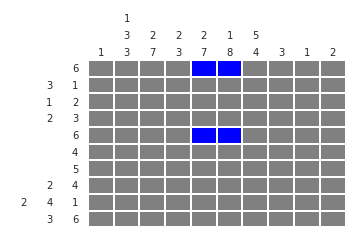

row: 6 const [5]


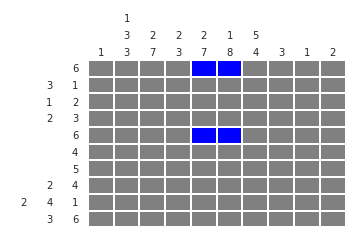

row: 7 const [2 4]


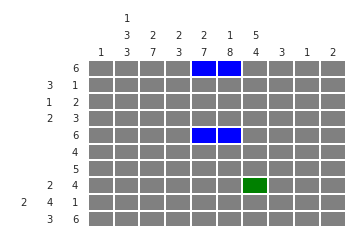

row: 8 const [2 4 1]


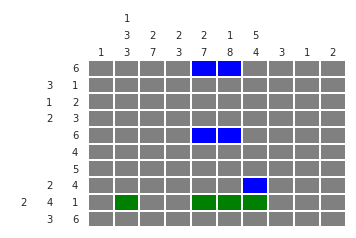

row: 9 const [3 6]


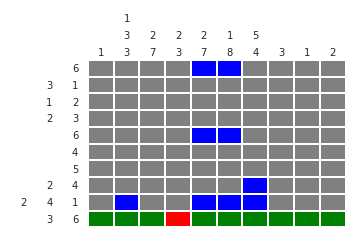

col: 0 const [1]


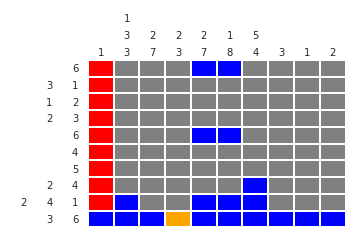

col: 1 const [1 3 3]


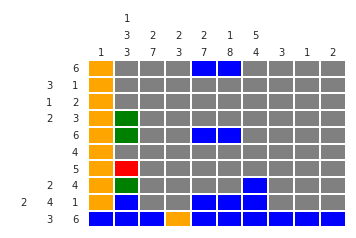

col: 2 const [2 7]


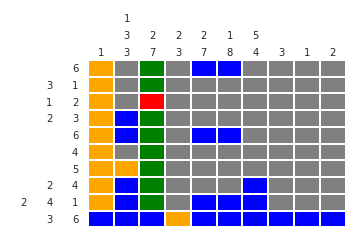

col: 3 const [2 3]


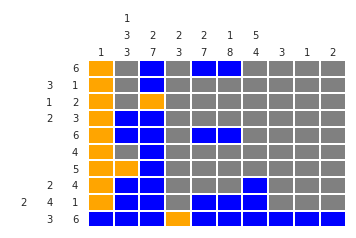

col: 4 const [2 7]


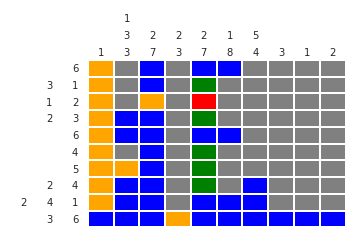

col: 5 const [1 8]


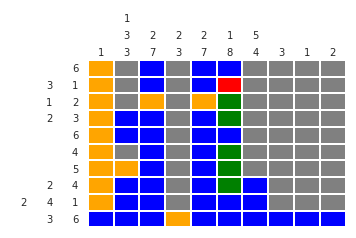

col: 6 const [5 4]


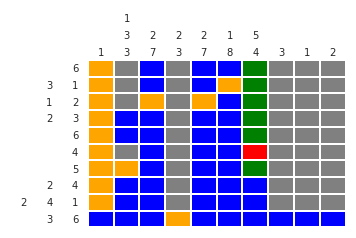

col: 7 const [3]


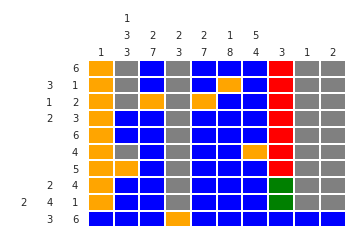

col: 8 const [1]


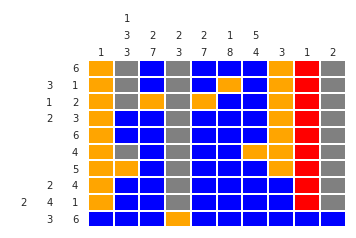

col: 9 const [2]


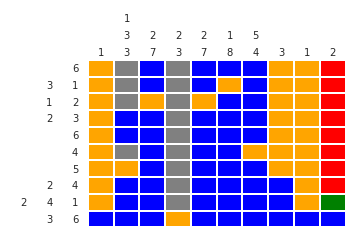

blank: 13
row: 0 const [6]


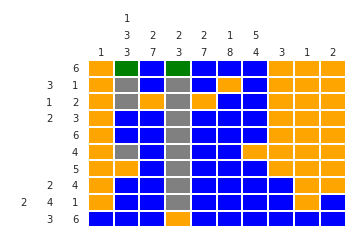

row: 1 const [3 1]


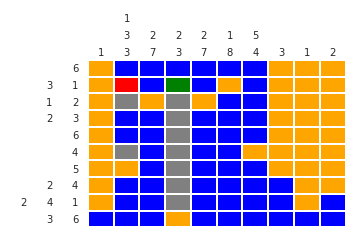

row: 2 const [1 2]


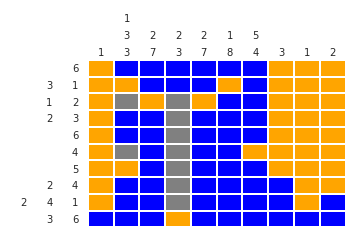

row: 3 const [2 3]


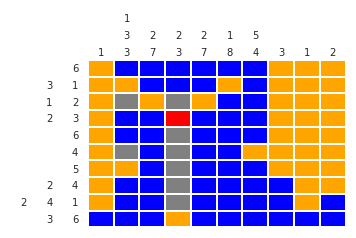

row: 4 const [6]


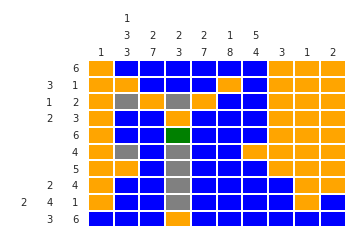

row: 5 const [4]


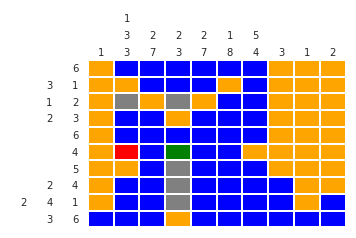

row: 6 const [5]


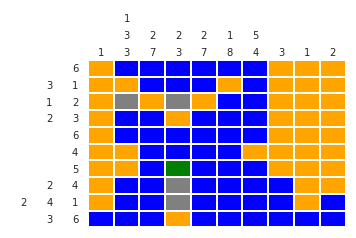

row: 7 const [2 4]


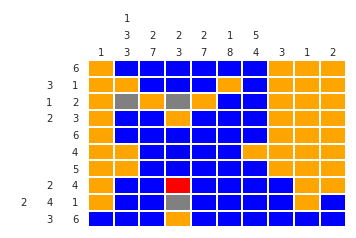

row: 8 const [2 4 1]


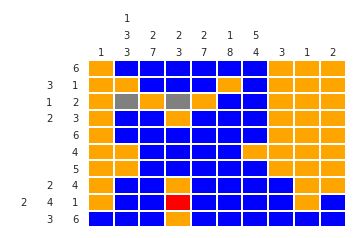

row: 9 const [3 6]
col: 0 const [1]
col: 1 const [1 3 3]


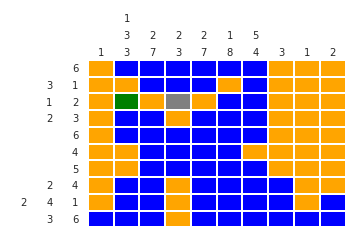

col: 2 const [2 7]
col: 3 const [2 3]


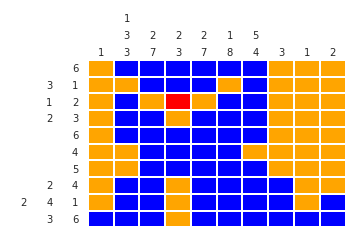

col: 4 const [2 7]
col: 5 const [1 8]
col: 6 const [5 4]
col: 7 const [3]
col: 8 const [1]
col: 9 const [2]
blank: 0


In [359]:
cols = '1 1,3,3 2,7 2,3 2,7 1,8 5,4 3 1 2'
rows = '6 3,1 1,2 2,3 6 4 5 2,4 2,4,1 3,6'
game = Nonogram(rows, cols)
game.solve()

row: 0 const [7]


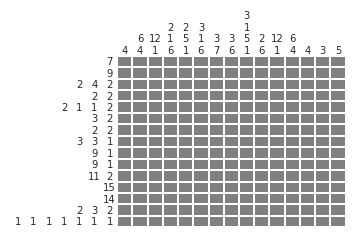

row: 1 const [9]


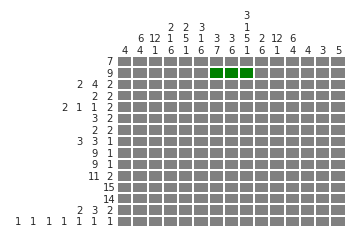

row: 2 const [2 4 2]


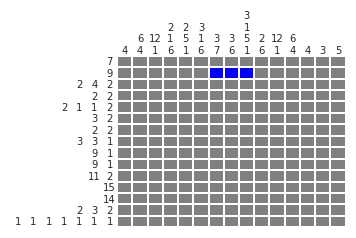

row: 3 const [2 2]


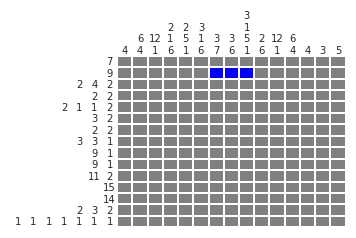

row: 4 const [2 1 1 2]


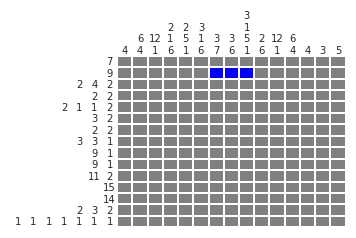

row: 5 const [3 2]


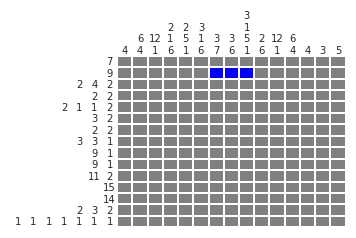

row: 6 const [2 2]


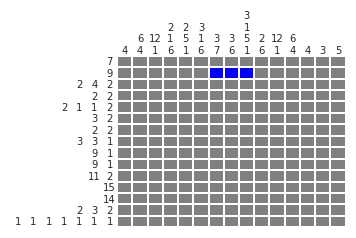

row: 7 const [3 3 1]


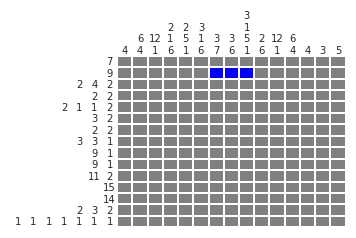

row: 8 const [9 1]


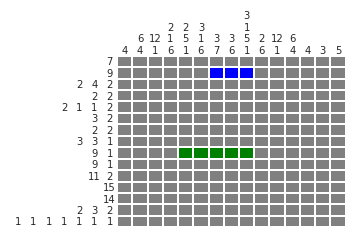

row: 9 const [9 1]


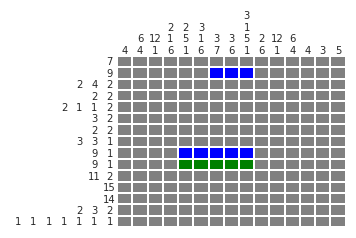

row: 10 const [11  2]


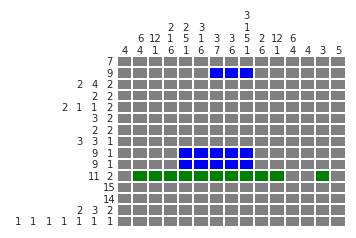

row: 11 const [15]


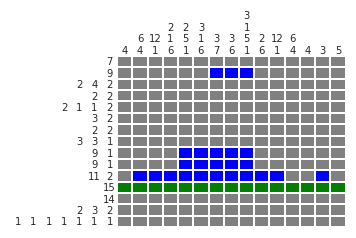

row: 12 const [14]


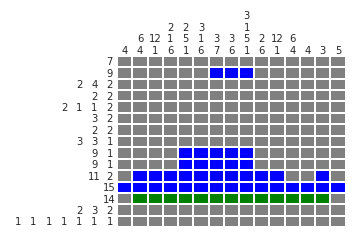

row: 13 const [2 3 2]


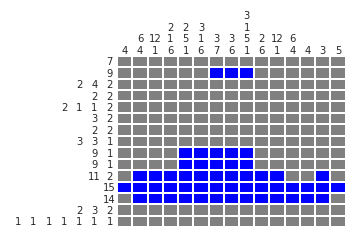

row: 14 const [1 1 1 1 1 1 1]


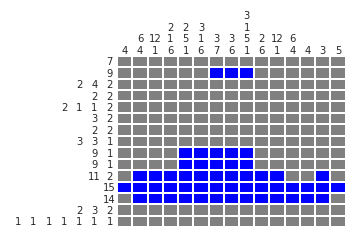

col: 0 const [4]


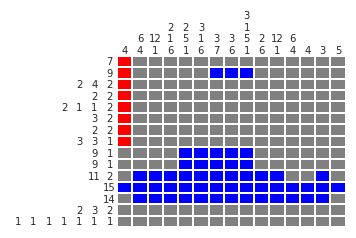

col: 1 const [6 4]


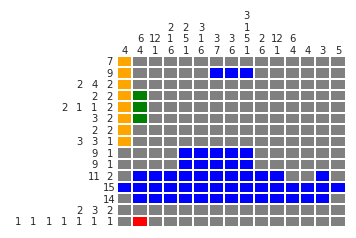

col: 2 const [12  1]


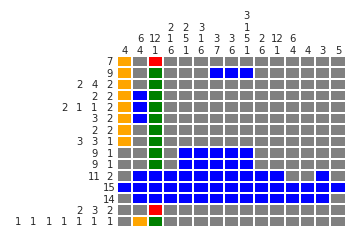

col: 3 const [2 1 6]


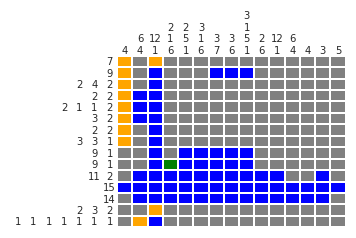

col: 4 const [2 5 1]


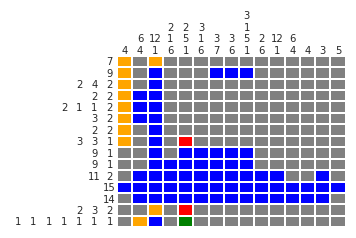

col: 5 const [3 1 6]


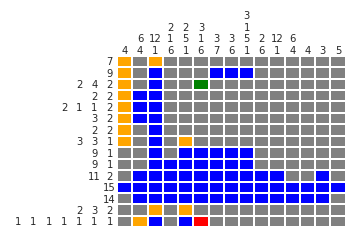

col: 6 const [3 7]


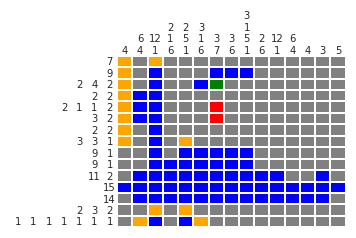

col: 7 const [3 6]


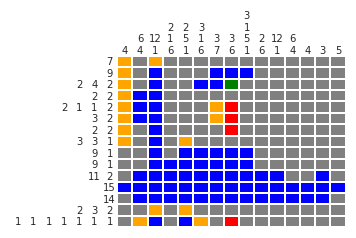

col: 8 const [3 1 5 1]


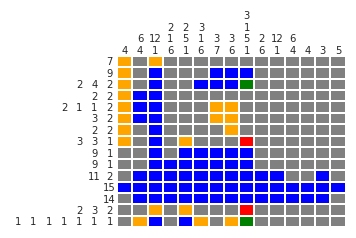

col: 9 const [2 6]


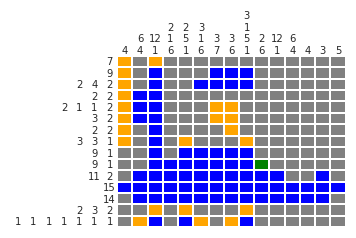

col: 10 const [12  1]


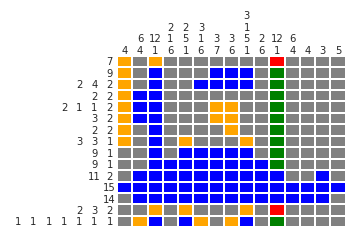

col: 11 const [6 4]


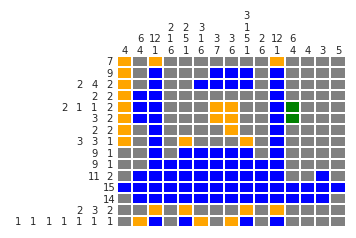

col: 12 const [4]


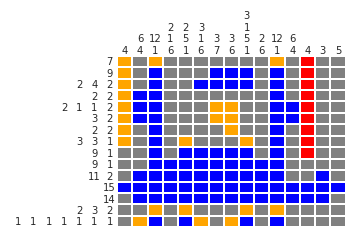

col: 13 const [3]


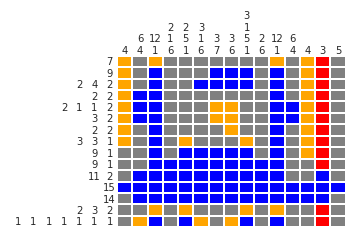

col: 14 const [5]


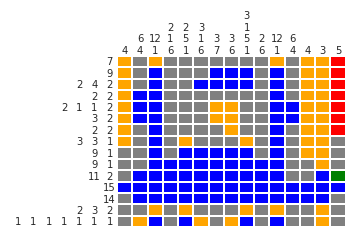

blank: 87
row: 0 const [7]


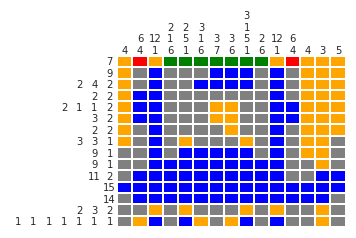

row: 1 const [9]


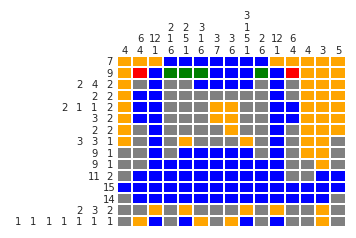

row: 2 const [2 4 2]


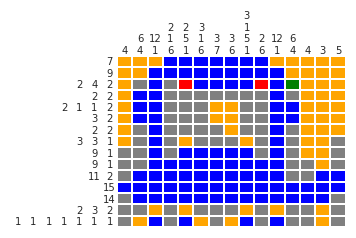

row: 3 const [2 2]


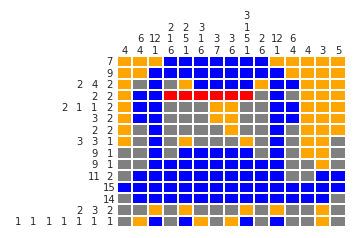

row: 4 const [2 1 1 2]


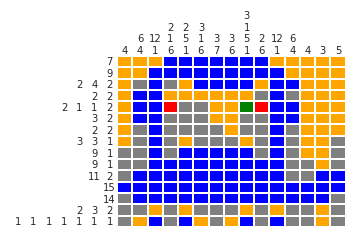

row: 5 const [3 2]


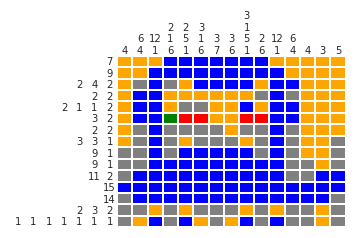

row: 6 const [2 2]


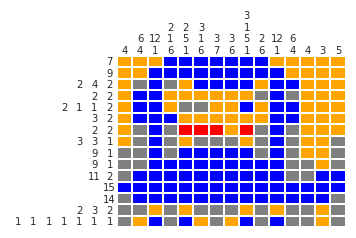

row: 7 const [3 3 1]


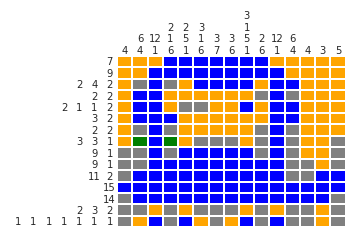

row: 8 const [9 1]


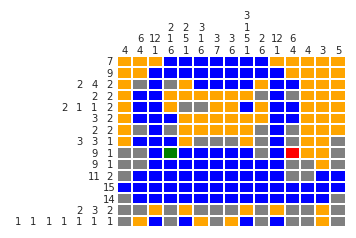

row: 9 const [9 1]


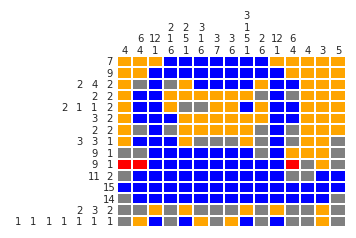

row: 10 const [11  2]


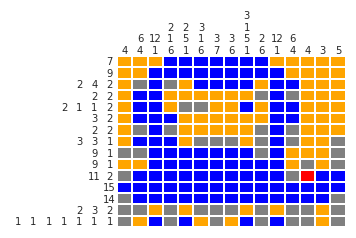

row: 11 const [15]
row: 12 const [14]


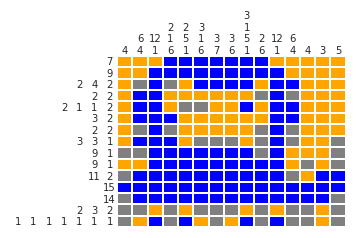

row: 13 const [2 3 2]


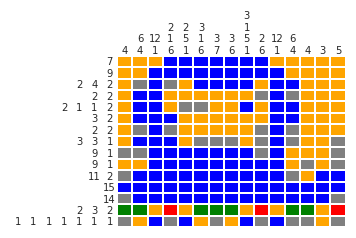

row: 14 const [1 1 1 1 1 1 1]


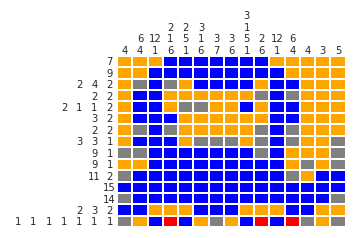

col: 0 const [4]


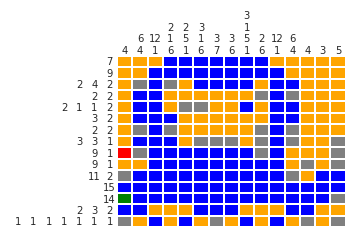

col: 1 const [6 4]


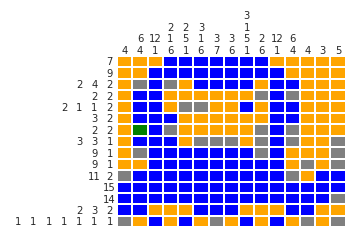

col: 2 const [12  1]
col: 3 const [2 1 6]


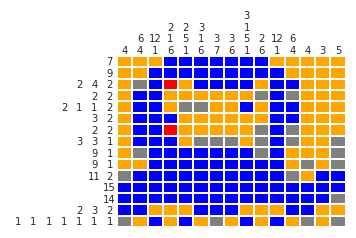

col: 4 const [2 5 1]


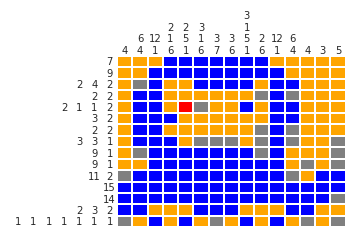

col: 5 const [3 1 6]


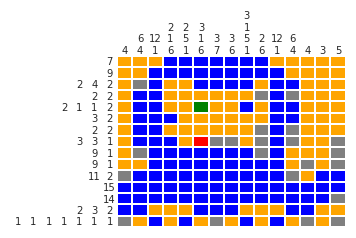

col: 6 const [3 7]


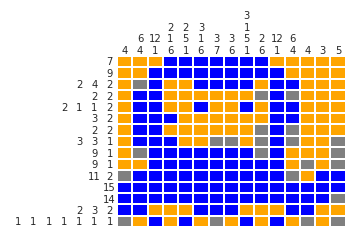

col: 7 const [3 6]


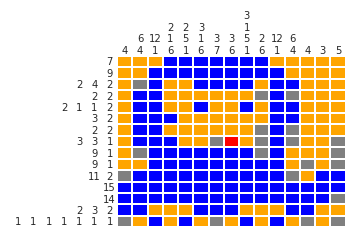

col: 8 const [3 1 5 1]
col: 9 const [2 6]


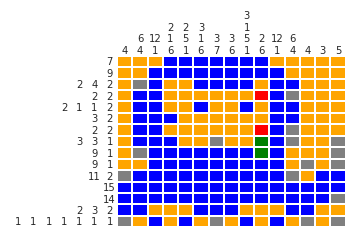

col: 10 const [12  1]
col: 11 const [6 4]


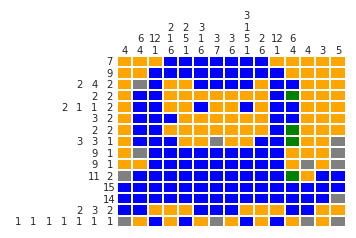

col: 12 const [4]


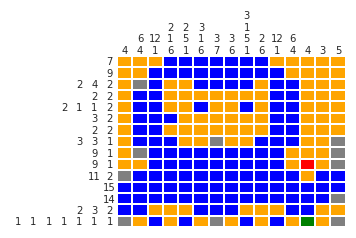

col: 13 const [3]
col: 14 const [5]


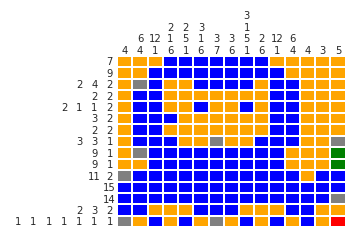

blank: 8
row: 0 const [7]
row: 1 const [9]
row: 2 const [2 4 2]


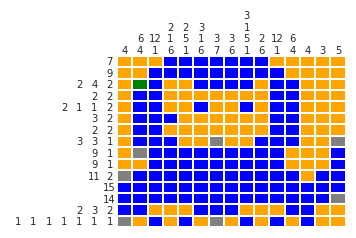

row: 3 const [2 2]
row: 4 const [2 1 1 2]
row: 5 const [3 2]
row: 6 const [2 2]
row: 7 const [3 3 1]


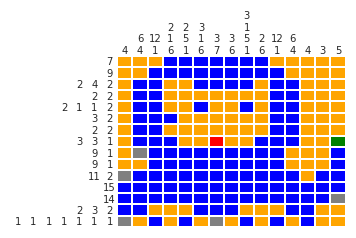

row: 8 const [9 1]


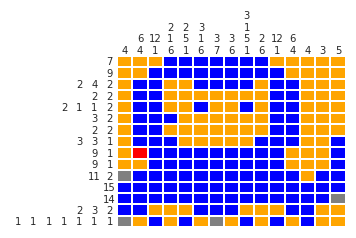

row: 9 const [9 1]
row: 10 const [11  2]


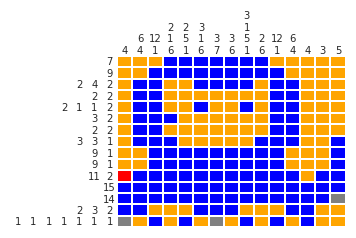

row: 11 const [15]
row: 12 const [14]


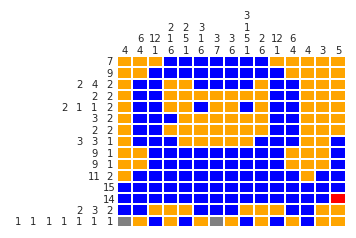

row: 13 const [2 3 2]
row: 14 const [1 1 1 1 1 1 1]


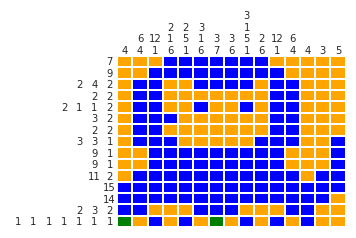

col: 0 const [4]
col: 1 const [6 4]
col: 2 const [12  1]
col: 3 const [2 1 6]
col: 4 const [2 5 1]
col: 5 const [3 1 6]
col: 6 const [3 7]
col: 7 const [3 6]
col: 8 const [3 1 5 1]
col: 9 const [2 6]
col: 10 const [12  1]
col: 11 const [6 4]
col: 12 const [4]
col: 13 const [3]
col: 14 const [5]
blank: 0


In [360]:
cols = '4 6,4 12,1 2,1,6 2,5,1 3,1,6 3,7 3,6 3,1,5,1 2,6 12,1 6,4 4 3 5'
rows = '7 9 2,4,2 2,2 2,1,1,2 3,2 2,2 3,3,1 9,1 9,1 11,2 15 14 2,3,2 1,1,1,1,1,1,1'
game = Nonogram(rows, cols)
game.solve()